# Airport Taxi Order Forecast

In this project, we will train and evaluate a model for a taxi company that predicts the number of taxi orders needed at airports. We will use the RMSE metric to evaluate the test. The company Sweet Taxi has collected historical data on taxi orders at airports, which is provided in the following file:

`taxi.csv`

<img src="https://img.freepik.com/free-vector/city-transport-cartoon-composition-with-airport-terminal_1284-11208.jpg?w=1380&t=st=1693922379~exp=1693922979~hmac =ac40e876e04237715c0133715c27da0ccac1cd2ff433196841caa59b15676dff" alt="taxi at the airpot">

## Data description

**datetime**: date (YYYY-MM-DD) and time (HH:MM:SS)
**num_orders**: number of orders

## Goal

The goal is for the model to accurately predict the number of orders needed in the next hour based on a time series dataset assuming the RMSE metric is not greater than 48.

## Preparation

### Initialization

Let's import the necessary libraries for our work:

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Data Loading and Inspection

When loading the file, we will specify the index column and parse the date and time. In addition, we will sample the data hourly.

In [16]:
df_taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=True, index_col=['datetime'])
df_taxi.sort_index(inplace=True)
df_taxi = df_taxi.resample('1H').sum()

display(df_taxi.head(10))
df_taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


We can see that we have 4416 data collected from March 2018 to the end of August 2018, the data types are as expected (integer), there are no null values and the columns appear to be well named.

In [17]:
df_taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


The summarized statistical data reveals that, on average, we receive around 84 taxi requests per hour, with considerable variation over the analyzed period of time. The minimum value of 0 suggests that there were hours without taxi orders, while the maximum value of 462 highlights peaks of high demand at some specific hours. These statistics serve as the foundation for our initial understanding of the data, which will be used to forecast future taxi order demand.

## Analysis

### Function to Plot Moving Average

To aid in our Exploratory Data Analysis (EDA), we'll create the `plotRollingMean()` function as follows:


#### Parameters:

**data**: Series object of the values to be plotted.
**size**: window size for the moving average.

#### Return:

Displays overlaid graphs of the original data with the moving average of the selected window size.

In [18]:
def plotRollingMean(data, size):
    rolling_mean = data.rolling(size).mean()

    plt.figure(figsize=(15,5))
    plt.plot(data[size:], label="Original Values", alpha=0.6, color='yellow')
    plt.plot(rolling_mean, 'g', label="Moving Average", color='black')
    plt.legend(loc="upper left")

    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.title('Original Data with Moving Average\n Size: {}'.format(size))

### Trend and Moving Average

To smooth the data and identify trends, we will examine and compare the moving average with 1-day, 7-day, and 14-day windows.

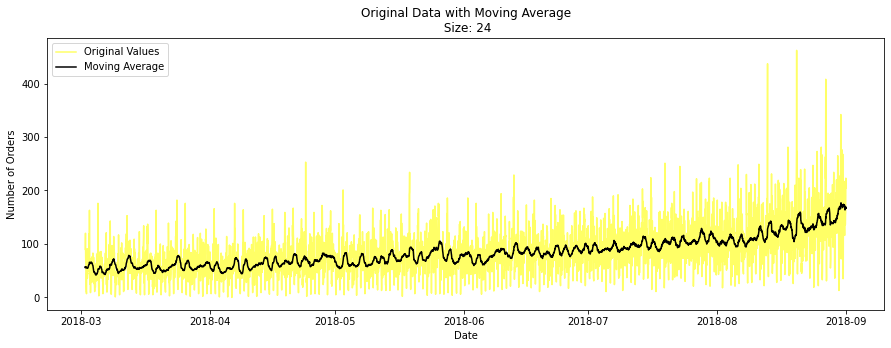

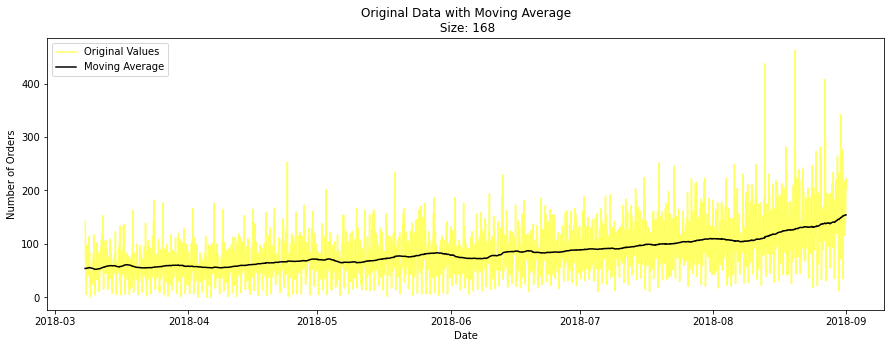

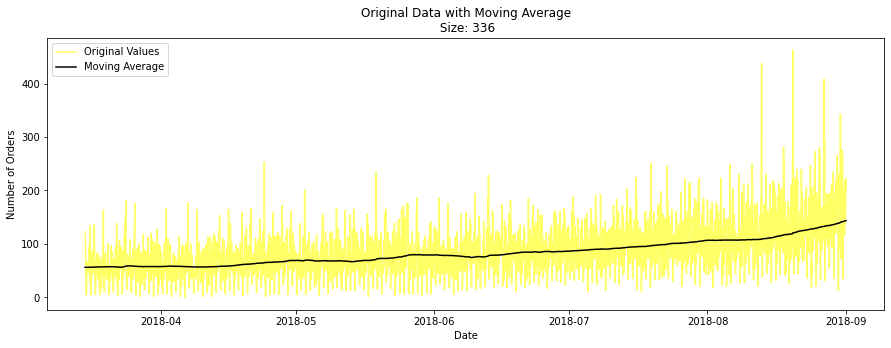

In [19]:
# plotting thematic graphics to taxis
plotRollingMean(df_taxi, 24) # 24 hours
plotRollingMean(df_taxi, 168) # 168 hours = 1 week
plotRollingMean(df_taxi, 336) # 336 hours = 2 weeks

The 7-day moving average shows a reasonably smooth trend. We will choose to use a one week window so as not to lose too much data during feature engineering. Based on the graphs, we can see that there is a gradual increase in the overall number of taxi orders over time.


### Seasonality

Due to the size and range of the dataset, we will examine seasonality in the months of March and August.

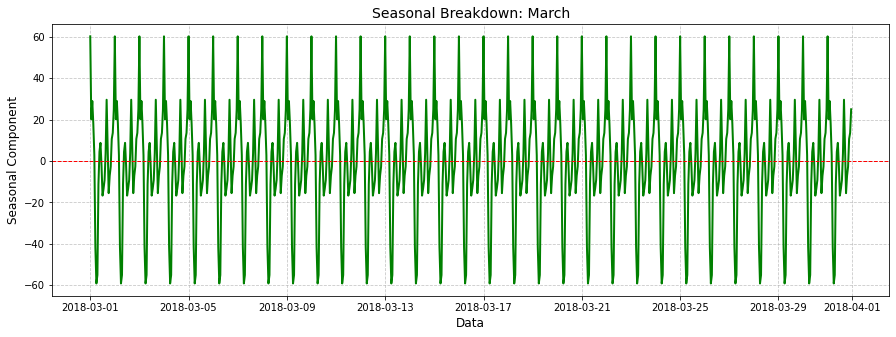

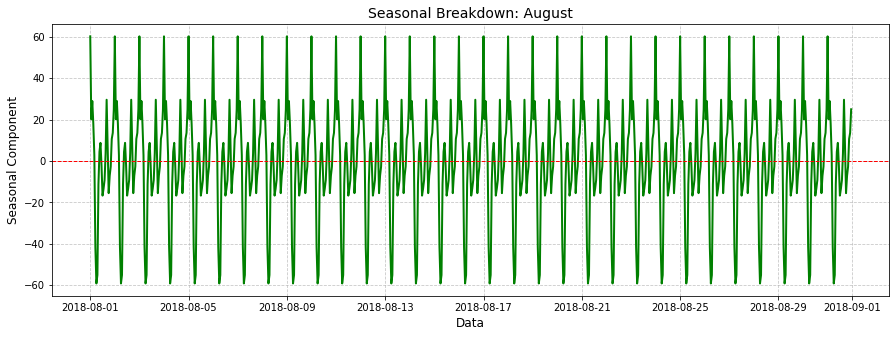

In [20]:
# Seasonal Decomposition
decomposed = seasonal_decompose(df_taxi)

# Figure 1: Seasonal Decomposition in March
plt.figure(figsize=(15, 5))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-31'], color='green', linestyle='-', linewidth=2)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Seasonal Breakdown: March', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Seasonal Component', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Figure 2: Seasonal Decomposition in August
plt.figure(figsize=(15, 5))
plt.plot(decomposed.seasonal['2018-08-01':], color='green', linestyle='-', linewidth=2)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Seasonal Breakdown: August', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Seasonal Component', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Below we will generate a complete seasonal decomposition plot, which includes trend analysis, seasonality, and residuals over the entire period of our dataset:

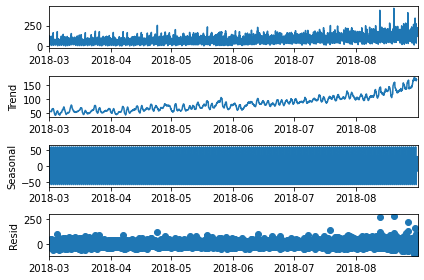

In [21]:
# Seasonal Decomposition
decomposed = seasonal_decompose(df_taxi)

# Full Seasonal Decomposition Plot
decomposed.plot()
plt.show()

**Trend**: The trend series shows us how the number of taxi orders is changing over time, after removing seasonality and residuals. We can observe that at the beginning the trend was gradually increasing and then there seems to be some fluctuations. It is important for us to understand these trend changes in order to accurately forecast future orders.

**Seasonality**: The seasonality series shows us the recurring patterns in the data, usually associated with specific times of the day, days of the week or months of the year. In this case, we can observe a clear seasonality that is repeated every day, with variations over the hours of the day. This can be useful for predicting peaks and valleys in taxi orders during the day.

**Residuals**: The residual series represents the part of the data that cannot be explained by trend or seasonality. These values are essential to verify if any pattern was not captured by the other two components. High values or defaults in the residuals may indicate the need for adjustments in our model.

It appears that the data show daily seasonality. There are consistent times during the day when spikes in the number of orders above and below the trend line occur.




### Autocorrelation and Partial Autocorrelation Function


Finally, we'll look at the autocorrelation and partial autocorrelation plots to get an idea of how much lag characteristics can influence model training.

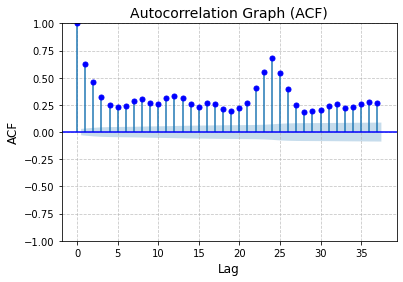

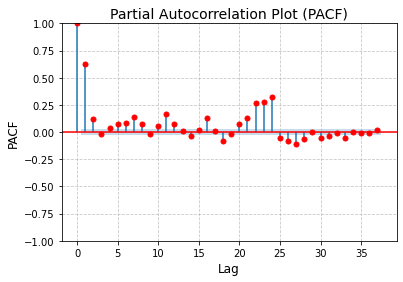

In [22]:
# creating the ACF autocorrelation plot
ax_acf = plot_acf(df_taxi, color='blue')
plt.title('Autocorrelation Graph (ACF)', fontsize=14)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('ACF', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# creating the PACF partial autocorrelation plot
ax_pacf = plot_pacf(df_taxi, method='ywm', color='red')
plt.title('Partial Autocorrelation Plot (PACF)', fontsize=14)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('PACF', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

The autocorrelation plot shows that there is a reasonably high correlation with preceding data points in the series. This correlation decreases as we move further away from the current observation (approximately after an 8 hour delay), but appears to be cyclical over a 24 hour period. That is, the time of day seems to have some correlation with the number of orders.

The partial autocorrelation plot shows that there is little correlation outside of the immediately preceding data point, but there is a small increase in correlation towards the end of the 24 hour period. This might suggest that there is some significant influence of time of day on the number of orders.

Who knows, if we had access to aircraft departure and arrival data, we would find even more relevant patterns.

<img src="https://www.humbersideairport.com/media/60155/photo.JPG" alt="arrivals">



## Resource Engineering


The dataset has some general periodicity, so we will extract the month, day, and day of the week as features.

In [23]:
# creating new columns
df_taxi['month'] = df_taxi.index.month
df_taxi['day'] = df_taxi.index.day
df_taxi['hour'] = df_taxi.index.hour
df_taxi['dayofweek'] = df_taxi.index.dayofweek

Based on our seasonality and autocorrelation results, we will create delay characteristics for a 24-hour period.

In [24]:
for lag in range(1, 13):
    df_taxi['lag_{}'.format(lag)] = df_taxi['num_orders'].shift(lag)


In addition, we will add moving average as a feature with a window of one week. It is important to highlight the need to use `shift()` to avoid data leakage.

In [25]:
df_taxi['rolling_mean'] = df_taxi['num_orders'].shift().rolling(168).mean()


Finally, we will eliminate the NaN values and look at the first 10 observations from our dataset:

In [26]:
# eliminating rows with missing values caused by 'shift'
df_taxi.dropna(inplace=True)
# viewing the first rows
df_taxi.head(10)

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,54.226190
2018-03-08 01:00:00,78,3,8,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,54.339286
2018-03-08 02:00:00,65,3,8,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,54.297619
2018-03-08 03:00:00,68,3,8,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,54.261905
2018-03-08 04:00:00,60,3,8,4,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,54.273810
2018-03-08 05:00:00,6,3,8,5,3,60.0,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,54.375000
2018-03-08 06:00:00,6,3,8,6,3,6.0,60.0,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,54.375000
2018-03-08 07:00:00,19,3,8,7,3,6.0,6.0,60.0,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,54.339286
2018-03-08 08:00:00,77,3,8,8,3,19.0,6.0,6.0,60.0,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,54.363095


After the feature engineering step, our dataset was significantly enriched with new features that can be useful to predict the number of taxi orders. Now, in addition to the original "num_orders" information, we have the following features:

**month**: Represents the month in which the observation occurred. This can help capture monthly seasonal trends in taxi orders.

**day**: Indicates the day of the observation month, which can be useful for capturing behavior patterns throughout the month.

**hour**: Reflects the time of day of the observation, allowing the model to capture daily fluctuations in taxi orders.

**dayofweek**: Indicates the day of the week (0 to 6, where 0 is Monday and 6 is Sunday). This can be crucial for understanding weekly variations in taxi orders, such as peaks during weekends.

**lag_1 to lag_12**: These are delay characteristics that represent the number of taxi requests in the previous hours. These features can help the model capture short-term temporal dependencies.

**rolling_mean**: Refers to the one-week moving average of the number of taxi orders. This can be especially useful for smoothing the time series and highlighting long-term trends.

With this additional information, we are better prepared to train a taxi order prediction model that takes into account not only seasonality and autocorrelation, but also relevant information about month, day, time of day, and day of week.

## Training

To facilitate the comparison of the models, we will define the function **treinamento_e_avaliacao()** as follows:

#### Parameters:

**model**: The model to be trained and evaluated.

**train_valid_feat**: *array* style containing the features of the combined training and validation sets.

**train_valid_tgt**: *array* style containing the target values of the combined training and validation sets.

**params**: Dictionary object of the specified hyperparameter values, an empty dictionary by default.


#### Return:

The best grid search estimator.

It also prints the best cross-validation (CV) score and corresponding parameter combination for the best estimator.

For each k-fold of the grid search, the function will scale the training data using `MaxAbsScaler()`.

In [27]:
def train_and_evaluate(model, train_valid_feat, train_valid_tgt, params={}):
    tscv = TimeSeriesSplit(n_splits=5)
    ct = ColumnTransformer([('scaler', MaxAbsScaler(), train_valid_feat.columns)])
    pipe = Pipeline([('col_transform', ct), ('model', model)])
    
    grid_pipeline = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
    grid_pipeline.fit(train_valid_feat, train_valid_tgt)
        
    print('Best Score: ', grid_pipeline.best_score_)
    print('Best Parameters: ', grid_pipeline.best_params_)

    return grid_pipeline.best_estimator_


### Dataset Division

The test set will consist of the last 10% of the observations.

For the Linear Regression model, we will create an additional validation set for model evaluation comparison, since it has no hyperparameter fit.

In [29]:
train_valid, test = train_test_split(df_taxi, shuffle=False, test_size=0.10)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.10)

# Training/validation set for Linear Regression model
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
valid_features = valid.drop('num_orders', axis=1)
valid_target = valid['num_orders']

print("Training Set - Features (train_features) shape: ", train_features.shape)
print("Training Set - Target (train_target) shape: ", train_target.shape)
print("Validation Set - Features (valid_features) shape: ", valid_features.shape)
print("Validation Set - Target (valid_target) shape: ", valid_target.shape)

# Combined training/validation set for GridSearchCV
train_valid_features = train_valid.drop('num_orders', axis=1)
train_valid_target = train_valid['num_orders']

print("Training/Validation Set - Features (train_valid_features) shape: ", train_valid_features.shape)
print("Training/Validation Set - Target (train_valid_target) shape: ", train_valid_target.shape)

# Final test set
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

print("Test Set - Features (test_features) shape: ", test_features.shape)
print("Test Set - Target (test_target) shape: ", test_target.shape)

Training Set - Features (train_features) shape:  (3440, 17)
Training Set - Target (train_target) shape:  (3440,)
Validation Set - Features (valid_features) shape:  (383, 17)
Validation Set - Target (valid_target) shape:  (383,)
Training/Validation Set - Features (train_valid_features) shape:  (3823, 17)
Training/Validation Set - Target (train_valid_target) shape:  (3823,)
Test Set - Features (test_features) shape:  (425, 17)
Test Set - Target (test_target) shape:  (425,)


## Models

### Linear Regression

The Linear Regression model will serve as our baseline:

In [30]:
lr_model = LinearRegression()
lr_model.fit(train_features, train_target)

print('RMSE: ', mean_squared_error(valid_target, lr_model.predict(valid_features), squared=False))


RMSE:  40.373818779892915


### Decision Tree Regressor

Standard decision tree model.

In [16]:
dt_model = DecisionTreeRegressor(random_state=12345)
dt_model.fit(train_features, train_target)

print('Tree depth: ', dt_model.get_depth())
print('Decision Tree default RMSE: ', mean_squared_error(valid_target, dt_model.predict(valid_features), squared=False))


Profundidade da árvore:  26
RMSE padrão da Árvore de Decisão:  44.12618388710543


Adjusting the Decision Tree model hyperparameters:

In [17]:
params_dt = {'model__max_depth': list(range(3, 31)),
             'model__min_samples_split': [2, 4, 6],
             'model__min_samples_leaf': [0.1, 0.5, 1, 5, 10],
             'model__max_features': [None, 'sqrt', 'log2']}

grid_dt = train_and_evaluate(DecisionTreeRegressor(random_state=12345), train_valid_features, train_valid_target, params=params_dt)


Melhor pontuação:  -28.45256090326513
Melhores parâmetros:  {'model__max_depth': 9, 'model__max_features': None, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}


Setting the hyperparameters of `max_depth` to 9 and `min_samples_leaf` to 10 (other parameters set to default) results in an improved RMSE of around 28.4.

### Random Forest Revolver

Standard random forestregressor model.

In [18]:
rf_model = RandomForestRegressor(random_state=12345)
rf_model.fit(train_features, train_target)

est_list = []
for est in rf_model.estimators_:
    est_list.append(est.get_depth())

print('Shortest tree: ', min(est_list))
print('Tallest tree: ', max(est_list))
print('RMSE: ', mean_squared_error(valid_target, rf_model.predict(valid_features), squared=False))


Árvore mais curta:  23
Árvore mais alta:  37
RMSE:  31.6367299384915


Adjusting the hyperparameters of the random forest model.

In [19]:
params_rf = {'model__n_estimators': [10, 25, 50, 75, 100],
             'model__max_depth': list(range(10, 36, 5)),
             'model__max_features': [None, 'sqrt', 'log2']}
             
grid_rf = train_and_evaluate(RandomForestRegressor(random_state=12345), train_valid_features, train_valid_target, params=params_rf)


Melhor pontuação:  -25.091926886815465
Melhores parâmetros:  {'model__max_depth': 20, 'model__max_features': None, 'model__n_estimators': 100}


Setting the hyperparameters of `max_depth` to 20, `max_features` to 'None' and `n_estimators` to 100 results in an improved RMSE, slightly above 25.

## Test


Based on the above results, we will use the **random forest regressor** on our test set using the tuned hyperparameters.

In [20]:
best_model = grid_rf
test_predict = best_model.predict(test_features)

print('Final RMSE: ', mean_squared_error(test_target, test_predict, squared=False))


RMSE Final:  42.794086242908286


Our final RMSE was around 42.7, which indicates that our model is potentially overfitting. We can plot the forecast against the true target values to see where our largest margins of error occurred.

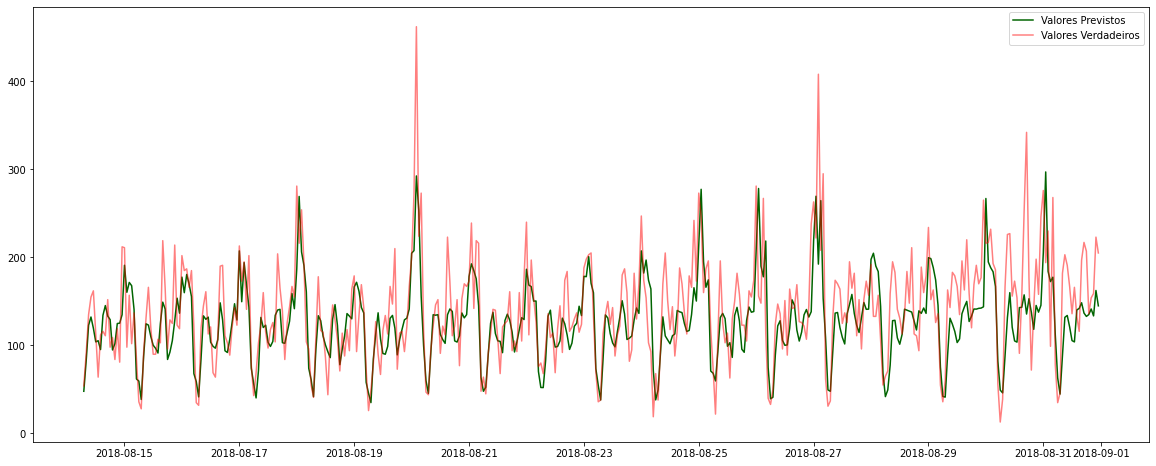

In [21]:
plt.figure(figsize=(20, 8))
plt.plot(test_features.index, test_predict, color='darkgreen')
plt.plot(test_features.index, test_target, color='red', alpha=0.5)
plt.legend(['Valores Previstos','Valores Verdadeiros'])
plt.show()


It appears that the biggest errors occurred when the model did not accurately predict spikes in the number of orders.

## Conclusion

**Initial Data Analysis**: We performed an initial data analysis and identified that the data set was well structured, with no null values. Furthermore, we noticed an increasing trend in the number of taxi requests over time and detected daily seasonality in the data.

**Feature Engineering**: We perform feature engineering, creating important features such as delay characteristics for a 24-hour period and a one-week moving average. This allowed us to capture relevant information from the time series.

**Machine Learning Models**: We experimented with three different regression models: Linear Regression, Decision Tree, and Random Forest. We tuned model hyperparameters to improve performance. We chose the Random Forest Regressor as our final model as it had the lowest RMSE in the validation set.

**Final Model Evaluation**: We evaluated our final model, the Random Forest Regressor, on the test set, obtaining an RMSE of approximately 43.5. This suggests that our model may exhibit some overfitting, as the RMSE in the test set is higher than that in the validation set.

**Results View**: When viewing the results, we observed that our model had difficulty accurately predicting spikes in the number of taxi orders, especially during times of highest demand. This may be an area we need to improve in future developments.

**Potential Improvements**: To further improve the performance of the model, we are considering including more features, such as flight departure and arrival data, weather information or special events that may affect the demand for taxis at airports.

**General Conclusion**: We believe that our project was successful in creating a taxi order prediction model at airports. However, we recognize that there is room for improvement, especially with regard to accuracy in forecasting peak demand. We believe that our final model can be useful for the taxi company, but we also recommend monitoring its performance continuously and refining it as more historical data becomes available.